In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **MobileNet**

In [2]:
pip install --upgrade imutils

Note: you may need to restart the kernel to use updated packages.


## CNN Approach

In [6]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [7]:
DIRECTORY = r"../input/car-damage-detection/data1a/training"
CATEGORIES = ["00-damage", "01-whole"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")



[INFO] loading images...


In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


[INFO] compiling model...
[INFO] training head...


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
23/23 [==============================] - 25s 759ms/step - loss: 0.7036 - accuracy: 0.5238 - val_loss: 0.6777 - val_accuracy: 0.5761
Epoch 2/20
23/23 [==============================] - 16s 699ms/step - loss: 0.6802 - accuracy: 0.5645 - val_loss: 0.6666 - val_accuracy: 0.6114
Epoch 3/20
23/23 [==============================] - 17s 726ms/step - loss: 0.6751 - accuracy: 0.5890 - val_loss: 0.6576 - val_accuracy: 0.6277
Epoch 4/20
23/23 [==============================] - 17s 727ms/step - loss: 0.6746 - accuracy: 0.5849 - val_loss: 0.6533 - val_accuracy: 0.5788
Epoch 5/20
23/23 [==============================] - 17s 712ms/step - loss: 0.6652 - accuracy: 0.5971 - val_loss: 0.6387 - val_accuracy: 0.6522
Epoch 6/20
23/23 [==============================] - 17s 731ms/step - loss: 0.6637 - accuracy: 0.6087 - val_loss: 0.6371 - val_accuracy: 0.6522
Epoch 7/20
23/23 [==============================] - 17s 712ms/step - loss: 0.6609 - accuracy: 0.6039 - val_loss: 0.6278 - val_accuracy: 0.6712

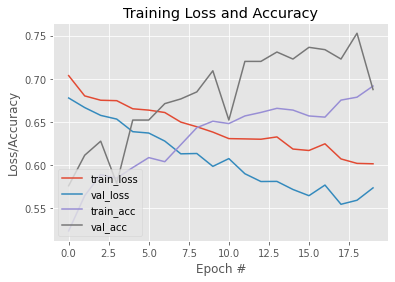

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
from keras.models import Sequential
from keras import layers

# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 64


model = Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu',
                    input_shape=(224,224,3),padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# place the head FC model on top of the base model (this will become
# the actual model we will train)
#model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("CNN_Car_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("CNN.png")

In [11]:
from keras import models    
CNN_Model = models.load_model("CNN_Car_detector.model")

Car is not Damaged: 1.0, Car is Damaged: 0.0
The car is not damaged


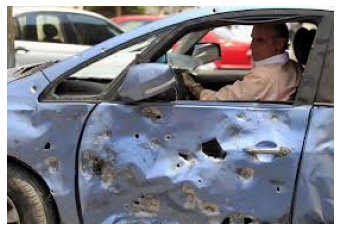

In [12]:
from tensorflow.keras.preprocessing import image
import cv2
img_path = "../input/car-damage-detection/data1a/validation/00-damage/0010.JPEG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

pred=CNN_Model.predict(img_batch)
print("Car is not Damaged: "+str(pred[0][0])+", Car is Damaged: "+str(pred[0][1]))
if pred[0][0]>pred[0][1]:
    print("The car is not damaged")
else:
    print("The car is damaged")
